In [1]:
pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 53.3 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import numpy as np
import tensorflow as tf
from tensorflow import keras

RDLogger.DisableLog("rdApp.*")

29856825/29856825 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
SMILES: Cn1cncc1O
Num heavy atoms: 7


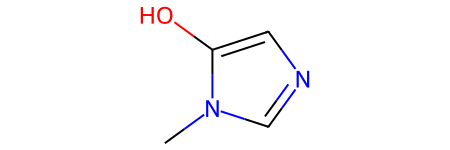

In [3]:
csv_path = tf.keras.utils.get_file(
    "qm9.csv", "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
)

data = []
with open(csv_path, "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

smiles = data[1000]
print("SMILES:", smiles)
molecule = Chem.MolFromSmiles(smiles)
print("Num heavy atoms:", molecule.GetNumHeavyAtoms())
molecule

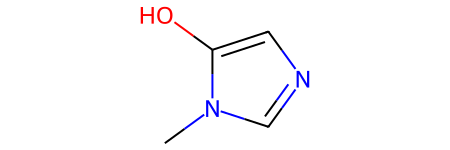

In [4]:
atom_mapping = {
    "C": 0,
    0: "C",
    "N": 1,
    1: "N",
    "O": 2,
    2: "O",
    "F": 3,
    3: "F",
}

bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}

NUM_ATOMS = 9  # Maximum number of atoms
ATOM_DIM = 4 + 1  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 64  # Size of the latent space


def smiles_to_graph(smiles):
    molecule = Chem.MolFromSmiles(smiles)

    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(graph):
    adjacency, features = graph
    molecule = Chem.RWMol()
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

graph_to_molecule(smiles_to_graph(smiles))

In [5]:
adjacency_tensor, feature_tensor = [], []
for smiles in data[::10]:
    adjacency, features = smiles_to_graph(smiles)
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)

print("adjacency_tensor.shape =", adjacency_tensor.shape)
print("feature_tensor.shape =", feature_tensor.shape)

adjacency_tensor.shape = (13389, 5, 9, 9)
feature_tensor.shape = (13389, 9, 5)


In [6]:
class SymmetrizeLayer(keras.layers.Layer):
    def call(self, inputs):
        return (inputs + tf.transpose(inputs, (0, 1, 3, 2))) / 2

In [7]:

def GraphGenerator(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    z = keras.layers.Input(shape=(latent_dim,))
    
    x = z
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    x_adjacency = keras.layers.Dense(int(tf.math.reduce_prod(adjacency_shape)))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    
    x_adjacency = SymmetrizeLayer()(x_adjacency)
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    x_features = keras.layers.Dense(int(tf.math.reduce_prod(feature_shape)))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)

    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="Generator")

generator = GraphGenerator(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM)
)


generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     33,024 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    131,584 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 405)       │    207,765 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 9, 9)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 45)        │     23,085 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ symmetrize_layer    │ (None, 5, 9, 9)   │          0 │ reshape[0][0]     │
│ (SymmetrizeLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 9, 5)      │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 5, 9, 9)   │          0 │ symmetrize_layer… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 9, 5)      │          0 │ reshape_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 403,778 (1.54 MB)

 Trainable params: 403,778 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        x = tf.matmul(adjacency, features[:, None, :, :])
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        x_reduced = tf.reduce_sum(x, axis=1)
        return self.activation(x_reduced)


def GraphDiscriminator(
    gconv_units, dense_units, dropout_rate, adjacency_shape, feature_shape
):

    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)

    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )

    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    for units in dense_units:
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    x_out = keras.layers.Dense(1, dtype="float32")(x)

    return keras.Model(inputs=[adjacency, features], outputs=x_out)


discriminator = GraphDiscriminator(
    gconv_units=[128, 128, 128, 128],
    dense_units=[512, 512],
    dropout_rate=0.2,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5, 9, 9)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 9, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 9, 128)    │      3,200 │ input_layer_1[0]… │
│ (RelationalGraphCo… │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 9, 128)    │     81,920 │ input_layer_1[0]… │
│ (RelationalGraphCo… │                   │            │ relational_graph… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 9, 128)    │     81,920 │ input_layer_1[0]… │
│ (RelationalGraphCo… │                   │            │ relational_graph… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 9, 128)    │     81,920 │ input_layer_1[0]… │
│ (RelationalGraphCo… │                   │            │ relational_graph… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ relational_graph… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │     66,048 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    262,656 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        513 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 578,177 (2.21 MB)

 Trainable params: 578,177 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
class GraphWGAN(keras.Model):
    def __init__(
        self,
        generator,
        discriminator,
        discriminator_steps=1,
        generator_steps=1,
        gp_weight=10,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.gp_weight = gp_weight
        self.latent_dim = self.generator.input_shape[-1]

    def compile(self, optimizer_generator, optimizer_discriminator, **kwargs):
        super().compile(**kwargs)
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.metric_generator = keras.metrics.Mean(name="loss_gen")
        self.metric_discriminator = keras.metrics.Mean(name="loss_dis")

    def train_step(self, inputs):

        if isinstance(inputs[0], tuple):
            inputs = inputs[0]

        graph_real = inputs

        self.batch_size = tf.shape(inputs[0])[0]

        for _ in range(self.discriminator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_discriminator(graph_real, graph_generated)

            grads = tape.gradient(loss, self.discriminator.trainable_weights)
            self.optimizer_discriminator.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            self.metric_discriminator.update_state(loss)

        for _ in range(self.generator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_generator(graph_generated)

                grads = tape.gradient(loss, self.generator.trainable_weights)
                self.optimizer_generator.apply_gradients(
                    zip(grads, self.generator.trainable_weights)
                )
                self.metric_generator.update_state(loss)

        return {m.name: m.result() for m in self.metrics}

    def _loss_discriminator(self, graph_real, graph_generated):
        logits_real = self.discriminator(graph_real, training=True)
        logits_generated = self.discriminator(graph_generated, training=True)
        loss = tf.reduce_mean(logits_generated) - tf.reduce_mean(logits_real)
        loss_gp = self._gradient_penalty(graph_real, graph_generated)
        return loss + loss_gp * self.gp_weight

    def _loss_generator(self, graph_generated):
        logits_generated = self.discriminator(graph_generated, training=True)
        return -tf.reduce_mean(logits_generated)

    def _gradient_penalty(self, graph_real, graph_generated):
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            logits = self.discriminator(
                [adjacency_interp, features_interp], training=True
            )

        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )

In [10]:
with tf.device("/GPU:0"):
    wgan = GraphWGAN(generator, discriminator, discriminator_steps=1)

    wgan.compile(
        optimizer_generator=keras.optimizers.Adam(5e-4),
        optimizer_discriminator=keras.optimizers.Adam(5e-4),
    )

    wgan.fit([adjacency_tensor, feature_tensor], epochs=10, batch_size=16)

Epoch 1/10


I0000 00:00:1728062917.037553     112 service.cc:145] XLA service 0x7dfa50006b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728062917.037608     112 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1728062917.473379     112 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform


 35/837 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0000e+00 - loss_dis: -2.9137 - loss_gen: 0.2241  

I0000 00:00:1728062943.002055     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


837/837 ━━━━━━━━━━━━━━━━━━━━ 62s 35ms/step - loss: 0.0000e+00 - loss_dis: -7.2557 - loss_gen: 3.2587
Epoch 2/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0000e+00 - loss_dis: -1.2677 - loss_gen: 0.2436
Epoch 3/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0000e+00 - loss_dis: -1.4104 - loss_gen: 0.0387
Epoch 4/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0000e+00 - loss_dis: -1.6607 - loss_gen: 0.1555
Epoch 5/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0000e+00 - loss_dis: -1.3572 - loss_gen: -0.0821
Epoch 6/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0000e+00 - loss_dis: -1.6980 - loss_gen: 0.3014
Epoch 7/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0000e+00 - loss_dis: -1.9903 - loss_gen: 0.5583
Epoch 8/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0000e+00 - loss_dis: -1.8930 - loss_gen: 0.5575
Epoch 9/10
837/837 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0000e+00 - loss_dis: -1.8214 - loss_gen: 0.7640
Epoch 10/10
837/83

In [13]:
def print_smiles_grid(smiles_list, mols_per_row=5):
    for i in range(0, len(smiles_list), mols_per_row):
        row = smiles_list[i:i + mols_per_row]
        print(" | ".join(row))

molecules_with_smiles = sample(wgan.generator, batch_size=48)

molecules = [m[0] for m in molecules_with_smiles]
smiles_list = [m[1] for m in molecules_with_smiles]

MolsToGridImage(
    molecules[:25], molsPerRow=5, subImgSize=(150, 150)
)

print_smiles_grid(smiles_list[:25], mols_per_row=5)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
N=C1CC2(CNC2)NO1 | CCC(C)OC(C)C#N | CC1CC(C)(CO)C1 | CC1C(=O)C(CO)C1=O | CCN1C=C(C)C1=O
NN1C(=O)ONC2CC21 | C=O.CCNOCC | CC(C)C12CNC1C2=O | CCCC(C)C1=CCC1 | CC1C(=O)C(CO)C1=O
C#CCC.CCN(C)O | CCN1C=C(C)C1=O | O=C1COCC2CNC12 | CC1C(=O)C2NC3CC312 | CCC(C)OC(C)C#N
CC1(CO)CCC1 | CCN1C=C(C)C1=O | CC1C(=O)OOC2CC21 | NC1C(=O)ONC2CC21 | CC1C(=O)C(CO)C1=O
CC(C(=O)O)C1CC1O | CC1(CCCO)CNC1 | CC.CCCCCO | OC1CC2(CCC2)CO1 | CC1CCC1=O.CO


In [14]:
from rdkit.Chem import rdMolDescriptors

def print_formula_grid(molecules_list, mols_per_row=5):
    for i in range(0, len(molecules_list), mols_per_row):
        row = molecules_list[i:i + mols_per_row]
        print(" | ".join([rdMolDescriptors.CalcMolFormula(mol) for mol in row]))

print_formula_grid(molecules[:25], mols_per_row=5)

C5H9N3O | C7H13NO | C7H14O | C6H8O3 | C6H9NO
C4H7N3O2 | C5H13NO2 | C7H11NO | C9H16 | C6H8O3
C7H15NO | C6H9NO | C6H9NO2 | C7H9NO | C7H13NO
C6H12O | C6H9NO | C6H8O3 | C5H8N2O2 | C6H8O3
C6H10O3 | C7H15NO | C7H18O | C7H12O2 | C6H12O2


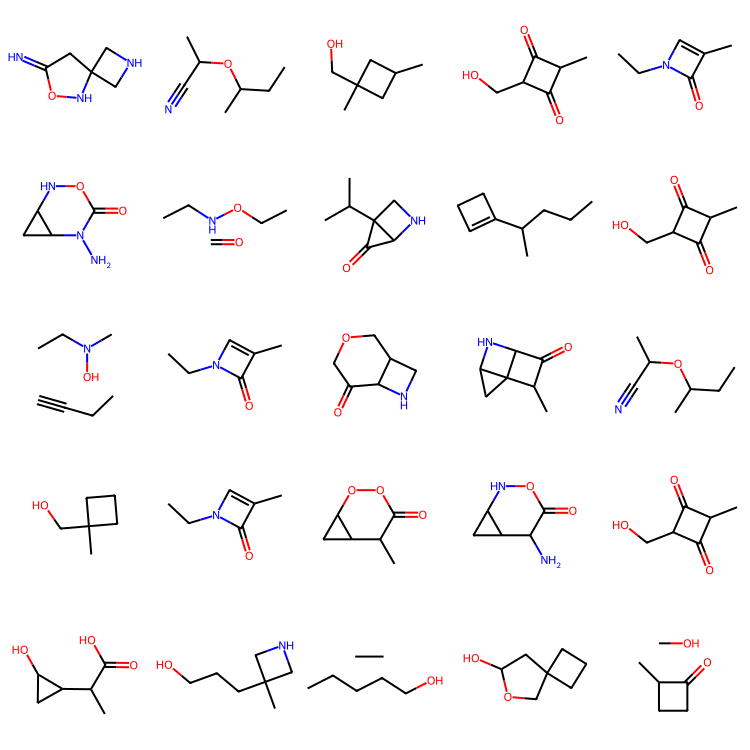

In [16]:
def sample(generator, batch_size):
    z = tf.random.normal((batch_size, LATENT_DIM))
    graph = generator.predict(z)
    
    adjacency = tf.argmax(graph[0], axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    
    features = tf.argmax(graph[1], axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
    
    molecules_with_smiles = []
    for i in range(batch_size):
        mol = graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
        if mol is not None:
            smiles = Chem.MolToSmiles(mol)
            molecules_with_smiles.append((mol, smiles))
    
    return molecules_with_smiles

MolsToGridImage(
    molecules[:25], molsPerRow=5, subImgSize=(150, 150)
)

In [15]:
latent_dim = generator.input_shape[-1]

def calculate_metrics(discriminator, real_graphs, generator, batch_size):
    noise = tf.random.normal([batch_size, latent_dim])
    fake_graphs = generator(noise)

    real_predictions = discriminator(real_graphs)
    fake_predictions = discriminator(fake_graphs)

    real_pred_labels = tf.cast(real_predictions > 0.5, tf.float32)
    fake_pred_labels = tf.cast(fake_predictions < 0.5, tf.float32)

    real_accuracy = tf.reduce_mean(real_pred_labels)
    fake_accuracy = tf.reduce_mean(fake_pred_labels)

    precision_real = tf.reduce_sum(real_pred_labels) / (tf.reduce_sum(real_pred_labels) + tf.reduce_sum(1 - fake_pred_labels))
    recall_real = tf.reduce_sum(real_pred_labels) / batch_size
    f1_real = 2 * precision_real * recall_real / (precision_real + recall_real)

    precision_fake = tf.reduce_sum(fake_pred_labels) / (tf.reduce_sum(fake_pred_labels) + tf.reduce_sum(1 - real_pred_labels))
    recall_fake = tf.reduce_sum(fake_pred_labels) / batch_size
    f1_fake = 2 * precision_fake * recall_fake / (precision_fake + recall_fake)

    overall_accuracy = (real_accuracy + fake_accuracy) / 2

    return overall_accuracy, precision_real, recall_real, f1_real, precision_fake, recall_fake, f1_fake

batch_size = 16  # Adjust based on your actual batch size
real_graphs = (adjacency_tensor[:batch_size], feature_tensor[:batch_size])
accuracy, precision_real, recall_real, f1_real, precision_fake, recall_fake, f1_fake = calculate_metrics(discriminator, real_graphs, generator, batch_size)

print(f"Discriminator accuracy: {accuracy * 100:.2f}%")
print(f"Real precision: {precision_real:.2f}, Real recall: {recall_real:.2f}, Real F1: {f1_real:.2f}")
print(f"Fake precision: {precision_fake:.2f}, Fake recall: {recall_fake:.2f}, Fake F1: {f1_fake:.2f}")

Discriminator accuracy: 96.88%
Real precision: 0.94, Real recall: 1.00, Real F1: 0.97
Fake precision: 1.00, Fake recall: 0.94, Fake F1: 0.97
